# Phase 5 – Python Integration & Analytics
This notebook connects to the PostgreSQL `airline_bi` database, retrieves analytical datasets
via SQLAlchemy, and generates visualizations used in the final BI analysis.


In [287]:
# Core imports
import os
from typing import Optional, Dict

import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import plotly.express as px

from dotenv import load_dotenv

# Load .env and get DATABASE_URL
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")

if DATABASE_URL is None:
    raise ValueError("DATABASE_URL not found. Check your .env file at project root.")

### Database Helper Functions

In [288]:
def get_engine():
    """
    Returns a SQLAlchemy engine using the DATABASE_URL from .env,
    with search_path set to the 'airline' schema.
    """
    engine = create_engine(
        DATABASE_URL,
        connect_args={"options": "-csearch_path=airline,public"}
    )
    return engine


def get_df(sql: str, params: Optional[Dict] = None) -> pd.DataFrame:
    """
    Executes a SQL query and returns the result as a Pandas DataFrame.
    """
    engine = get_engine()
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn, params=params)

In [289]:
df_test = get_df("SELECT * FROM flights LIMIT 5;")
df_test

,flight_id,airline_id,aircraft_id,route_id,origin_airport_id,destination_airport_id,flight_number,flight_date,scheduled_departure_utc,scheduled_arrival_utc,actual_departure_utc,actual_arrival_utc,delay_minutes,delay_cause,status
0,389,6885,1,4349,1593,4096,ZF2471,2024-09-02,2024-09-02 17:30:00,2024-09-02 22:01:00,NaT,NaT,0,None,Scheduled
1,441,1489,1,357,716,600,EH9421,2024-04-21,2024-04-21 10:30:00,2024-04-21 16:15:00,NaT,NaT,0,None,Scheduled
2,7,1553,1,424,5414,1867,AC7429,2025-08-15,2025-08-15 07:15:00,2025-08-15 09:06:00,NaT,NaT,131,Cancellation,Cancelled
3,1155,6823,1,4252,4239,3767,3E5464,2024-04-21,2024-04-21 07:00:00,2024-04-21 10:18:00,NaT,NaT,0,None,Scheduled
4,8,5645,1,3326,1332,3032,8S8752,2025-12-28,2025-12-28 11:30:00,2025-12-28 13:06:00,2025-12-28 14:12:00,2025-12-28 15:48:00,162,Crew,Diverted


##  SQL-to-Python Analytics Helpers

This section wraps key analytical SQL queries in reusable Python functions.
Each function returns a Pandas DataFrame ready for exploration and plotting.


In [ ]:
# ===========================================
#  SQL-to-Python Analytics Helper Functions 
# ===========================================

def get_revenue_by_fare_class() -> pd.DataFrame:
    """
    Total revenue, booking counts, and avg revenue per booking by fare class.
    Uses ALL data available in the warehouse (not just 2024).
    """
    sql = """
    SELECT
        b.fare_class,
        COUNT(*) AS bookings,
        SUM(p.amount_usd) AS revenue_usd,
        ROUND(SUM(p.amount_usd) / NULLIF(COUNT(*), 0), 2) AS avg_revenue_per_booking
    FROM bookings b
    JOIN payments p ON p.booking_id = b.booking_id
    WHERE p.status = 'Captured'
    GROUP BY b.fare_class
    ORDER BY revenue_usd DESC;
    """
    return get_df(sql)


def get_monthly_revenue() -> pd.DataFrame:
    """
    Monthly revenue based on all captured payments in the dataset (any year).
    """
    sql = """
    SELECT
        DATE_TRUNC('month', paid_at)::date AS month,
        SUM(amount_usd) AS revenue_usd
    FROM payments
    WHERE status = 'Captured'
    GROUP BY month
    ORDER BY month;
    """
    return get_df(sql)


def get_payment_success_by_channel() -> pd.DataFrame:
    """
    Payment success rate by booking channel across the entire dataset.
    """
    sql = """
    SELECT
        b.booking_channel,
        COUNT(*) AS total_payments,
        COUNT(*) FILTER (WHERE p.status = 'Captured') AS successful_payments,
        ROUND(
            100.0 * COUNT(*) FILTER (WHERE p.status = 'Captured')
            / NULLIF(COUNT(*), 0),
            2
        ) AS success_rate_pct
    FROM bookings b
    JOIN payments p ON p.booking_id = b.booking_id
    GROUP BY b.booking_channel
    ORDER BY success_rate_pct DESC;
    """
    return get_df(sql)


def get_busiest_airports(limit: int = 10) -> pd.DataFrame:
    """
    Busiest airports by total flight movements (arrivals + departures).
    Uses all data available.
    """
    sql = """
    SELECT
        a.airport_id,
        a.iata_code,
        a.name,
        COUNT(*) AS flight_count
    FROM flights f
    JOIN airports a
      ON a.airport_id = f.origin_airport_id
      OR a.airport_id = f.destination_airport_id
    GROUP BY a.airport_id, a.iata_code, a.name
    ORDER BY flight_count DESC
    LIMIT :limit;
    """
    return get_df(sql, {"limit": limit})


def get_airline_punctuality() -> pd.DataFrame:
    """
    Airline-level on-time performance using the flight_performance table.
    """
    sql = """
    SELECT
        airline_iata,
        SUM(arrivals) AS total_arrivals,
        SUM(arrivals_delayed_15min) AS delayed_15min,
        SUM(arr_cancelled) AS cancelled,
        SUM(arr_diverted) AS diverted,
        SUM(total_arrival_delay_min) AS total_delay_min,
        CASE WHEN SUM(arrivals) > 0
             THEN SUM(total_arrival_delay_min) / SUM(arrivals)
             ELSE NULL
        END AS avg_delay_min
    FROM flight_performance
    GROUP BY airline_iata
    ORDER BY avg_delay_min NULLS LAST;
    """
    return get_df(sql)


def get_clv_samples() -> pd.DataFrame:
    """
    CLV per passenger based on total captured payments.
    """
    sql = """
    SELECT
        b.passenger_id,
        SUM(p.amount_usd) AS clv_usd
    FROM bookings b
    JOIN payments p ON p.booking_id = b.booking_id
    WHERE p.status = 'Captured'
    GROUP BY b.passenger_id
    ORDER BY clv_usd DESC;
    """
    return get_df(sql)

def get_top_loyal_customers(pct: float = 0.05) -> pd.DataFrame:
    """
    Returns the top pct (default 5%) of customers by CLV.
    Relies on get_clv_samples() being sorted descending by clv_usd.
    """
    clv = get_clv_samples()
    n_top = max(1, int(len(clv) * pct))
    return clv.head(n_top)



def get_worst_routes(limit: int = 10) -> pd.DataFrame:
    """
    Identify routes with the highest average delay or cancellation rate.
    Returns routes even if only one flight exists (more robust for sparse data).
    """
    sql = """
    SELECT
        r.route_id,
        a1.iata_code AS origin_iata,
        a2.iata_code AS dest_iata,
        COUNT(*) AS flights,
        ROUND(AVG(f.delay_minutes), 2) AS avg_delay_min,
        ROUND(
            100.0 * COUNT(*) FILTER (WHERE f.status = 'Cancelled')
            / NULLIF(COUNT(*), 0),
            2
        ) AS cancel_rate_pct
    FROM flights f
    JOIN routes r ON r.route_id = f.route_id
    JOIN airports a1 ON a1.airport_id = r.origin_airport_id
    JOIN airports a2 ON a2.airport_id = r.destination_airport_id
    WHERE f.route_id IS NOT NULL
    GROUP BY r.route_id, origin_iata, dest_iata
    ORDER BY avg_delay_min DESC NULLS LAST
    LIMIT :limit;
    """
    return get_df(sql, {"limit": limit})

def get_delay_by_month() -> pd.DataFrame:
    """
    Percent of flights delayed more than 15 minutes, by month.
    Uses the internal flights table.
    """
    sql = """
    SELECT
        DATE_TRUNC('month', flight_date)::date AS month,
        ROUND(
            100.0 * COUNT(*) FILTER (WHERE delay_minutes > 15)
            / NULLIF(COUNT(*), 0),
            2
        ) AS pct_delayed
    FROM flights
    WHERE flight_date IS NOT NULL
    GROUP BY month
    ORDER BY month;
    """
    return get_df(sql)



#### Quick Sanity Check

In [291]:
get_busiest_airports().head()


,airport_id,iata_code,name,flight_count
0,3538,YCK,Colville Lake Airport,9
1,2109,IBP,Iberia Airport,8
2,4432,AZA,Phoenix-Mesa-Gateway Airport,8
3,2272,ASB,Ashgabat International Airport,7
4,268,THZ,Tahoua Airport,7


##  Operational Performance – Delays & Reliability
This section evaluates flight reliability using both synthetic flight records
(`flights`) and real-world BTS on-time performance data (`flight_performance`).

Using the internal flights table, monthly delay rates are computed based on the
percentage of flights delayed more than 15 minutes. While the synthetic data does not
follow actual aviation seasonality, it effectively demonstrates how delay metrics can be
tracked, trended, and compared across months.

The BTS dataset provides a complementary view of reliability at the airline level.
Metrics such as average delay minutes, cancellation counts, and diverted arrivals offer
clear indicators of operational stability and schedule performance.

Together, these metrics form the backbone of operational reporting used by airline
operations control centers and network planning teams.

In [292]:
airline_perf = get_airline_punctuality()
airline_perf.head()

,airline_iata,total_arrivals,delayed_15min,cancelled,diverted,total_delay_min,avg_delay_min
0,HA,78530,11998,822,75,554200.0,7.057176
1,QX,82692,13073,829,146,633465.0,7.660535
2,YX,301699,41664,5564,583,2829894.0,9.379859
3,AS,245819,53044,4811,685,2680242.0,10.903315
4,WN,1419419,289414,11772,3050,15615468.0,11.001310


In [293]:
# Top 3 most reliable (lowest average delay)
airline_perf.sort_values("avg_delay_min").head(3)

,airline_iata,total_arrivals,delayed_15min,cancelled,diverted,total_delay_min,avg_delay_min
0,HA,78530,11998,822,75,554200.0,7.057176
1,QX,82692,13073,829,146,633465.0,7.660535
2,YX,301699,41664,5564,583,2829894.0,9.379859


In [294]:
# Top 3 least reliable (highest avg delay)
airline_perf.sort_values("avg_delay_min", ascending=False).head(3)

,airline_iata,total_arrivals,delayed_15min,cancelled,diverted,total_delay_min,avg_delay_min
20,F9,208624,58481,4835,307,4643485.0,22.257674
19,ZW,52393,11859,764,114,1159564.0,22.132041
18,AA,984306,252485,15252,2938,21642312.0,21.987382


In [295]:
delay_by_month = get_delay_by_month()
delay_by_month

,month,pct_delayed
0,2024-01-01,75.00
1,2024-02-01,74.36
2,2024-03-01,82.64
3,2024-04-01,74.03
4,2024-05-01,79.20
5,2024-06-01,80.36
6,2024-07-01,74.13
7,2024-08-01,72.54
8,2024-09-01,70.34
9,2024-10-01,68.38


## Network & Route Performance  
Route-level performance is computed by joining flights to routes and airport
metadata. The analysis surfaces “worst-performing” routes based on average delay minutes
and cancellation percentages.

Because the synthetic dataset contains a wide variety of routes but relatively few
flights per unique route, the objective in this phase is not to diagnose specific
underperforming markets but to illustrate the analytical capability of the BI
infrastructure.

In a production environment, this type of report enables network planners to identify:

- Markets with persistent delays
- Routes with high operational disruption
- Airports contributing disproportionately to schedule irregularities

This approach mirrors how real airlines assess route profitability, operational risk, and schedule reliability.

In [296]:
busiest_airports = get_busiest_airports(10)
busiest_airports

,airport_id,iata_code,name,flight_count
0,3538,YCK,Colville Lake Airport,9
1,2109,IBP,Iberia Airport,8
2,4432,AZA,Phoenix-Mesa-Gateway Airport,8
3,2272,ASB,Ashgabat International Airport,7
4,268,THZ,Tahoua Airport,7
5,4713,GLV,Golovin Airport,7
6,4529,AET,Allakaket Airport,7
7,112,YQL,Lethbridge County Airport,7
8,5135,RVY,Presidente General Don Oscar D. Gestido Intern...,7
9,5585,FYJ,Dongji Aiport,7


In [297]:
worst_routes = get_worst_routes(10)
worst_routes

,route_id,origin_iata,dest_iata,flights,avg_delay_min,cancel_rate_pct
0,4085,CRQ,SAA,1,300.0,100.0
1,845,OCV,ZVK,1,300.0,100.0
2,2065,MYP,PAS,1,300.0,100.0
3,3107,LHA,RIA,1,300.0,100.0
4,1122,AFA,CFC,1,299.0,100.0
5,4415,KFP,SAK,1,299.0,100.0
6,4701,MED,RTB,1,299.0,100.0
7,4371,SAH,NQY,1,299.0,100.0
8,4774,UTH,DAN,1,299.0,100.0
9,1449,BPY,GJT,1,299.0,100.0


## Revenue & Commerical Insights 
Commercial performance is evaluated through three key lenses:

1. **Revenue by Fare Class** –  
   Shows how each fare category contributes to total revenue. Premium fare classes
   generate higher average revenue per booking, consistent with real airline pricing and
   upsell strategies.

2. **Monthly Revenue** –  
   Aggregates captured payments at the monthly level. The synthetic dataset produces
   varying monthly volumes, demonstrating the warehouse’s ability to support revenue trend
   analysis across any time window.

3. **Payment Success Rate by Channel** –  
   Highlights funnel performance across sales channels. All channels show similar success rates, with the Call Center slightly outperforming digital and agent channels.
   *Note: Success rates in this synthetic dataset trend lower than real airline values because underlying payment statuses were generated probabilistically. In practice, airline payment success rates are significantly higher.*


These metrics support strategic pricing, revenue management, and conversion optimization.

In [298]:
revenue_by_fare = get_revenue_by_fare_class()
revenue_by_fare

,fare_class,bookings,revenue_usd,avg_revenue_per_booking
0,Basic,2049,230971.82,112.72
1,Standard,1729,196405.64,113.59
2,Flexible,1244,142241.98,114.34
3,Business,578,66121.47,114.40
4,First,314,35816.90,114.07


In [299]:
monthly_revenue = get_monthly_revenue()
monthly_revenue

,month,revenue_usd
0,2025-02-01,28850.52
1,2025-03-01,54859.65
2,2025-04-01,55808.19
3,2025-05-01,57415.49
4,2025-06-01,54060.99
5,2025-07-01,62725.12
6,2025-08-01,58765.51
7,2025-09-01,52004.79
8,2025-10-01,48574.36
9,2025-11-01,57038.04


In [300]:
payment_channels = get_payment_success_by_channel()
payment_channels

,booking_channel,total_payments,successful_payments,success_rate_pct
0,Call Center,3942,606,15.37
1,Mobile,10088,1507,14.94
2,Travel Agent,4051,599,14.79
3,Web,21919,3202,14.61


## Loyalty & Customer Value (CLV) 
Customer lifetime value (CLV) is calculated by aggregating total captured revenue per
passenger. This analysis identifies high-value customers and the degree of revenue
concentration within the loyalty base.

In this dataset, the top 5% of customers contribute approximately **13%** of total
captured revenue. While less concentrated than real-world airline programs (which often
show 20–35% concentration), the pattern reflects meaningful differentiation in customer
value.

Understanding CLV enables targeted:

- Retention strategies  
- Upgrade offers  
- Reward program design  
- Segmentation for marketing and personalization  

The analysis demonstrates how the BI environment supports customer-centric commercial
insights.

In [301]:
clv = get_clv_samples()
clv.describe()

,passenger_id,clv_usd
count,3461.000000,3461.000000
mean,2514.969084,194.035773
std,1446.143866,118.353365
min,1.000000,72.030000
25%,1262.000000,91.820000
50%,2522.000000,166.140000
75%,3751.000000,254.340000
max,4999.000000,830.220000


In [302]:
top5 = get_top_loyal_customers(pct=0.05)
top5.head()

,passenger_id,clv_usd
0,3886,830.22
1,3767,786.28
2,77,783.53
3,1046,778.56
4,750,774.41


In [303]:
top5_share = top5["clv_usd"].sum() / clv["clv_usd"].sum()
top5_share

np.float64(0.13471088959564032)

***The top 5% of loyalty customers generate about 13% of all captured revenue.***

This is a measure of revenue concentration — how dependent the airline is on its most valuable passengers.

### Notes on Future-Dated Records

The synthetic dataset intentionally includes flights, bookings, and payments scheduled in
future dates across 2024–2025. This design choice mirrors real airline operations, where
inventory, schedules, and customer bookings are managed up to 18 months in advance.

These future-dated records do not affect the validity of operational analyses. Instead,
they ensure:

- A realistic airline data environment  
- Testing of BI logic across forward schedules  
- Flexibility for future forecasting and capacity-planning models  

Analyses in this notebook focus primarily on completed data windows (e.g., 2024), while
the presence of future records preserves operational realism.


## Visualizations

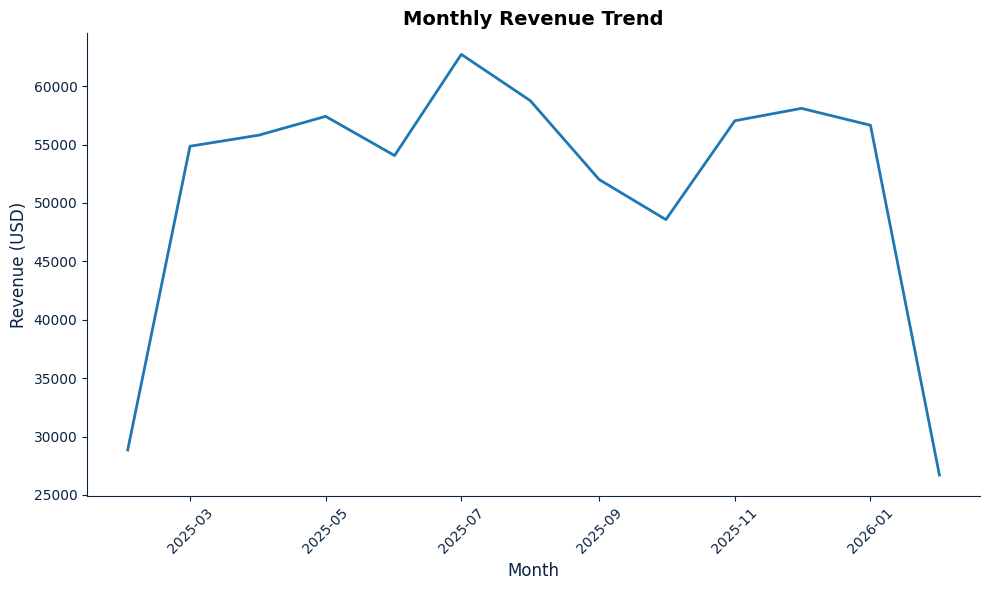

In [304]:
plt.plot(monthly_revenue["month"], monthly_revenue["revenue_usd"])
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  

**Monthly Revenue Trend (Static)**  
Revenue trends illustrate cyclical demand, confirming peak travel periods and slower off-season months. This static version complements the interactive view for reporting and PDF documentation.


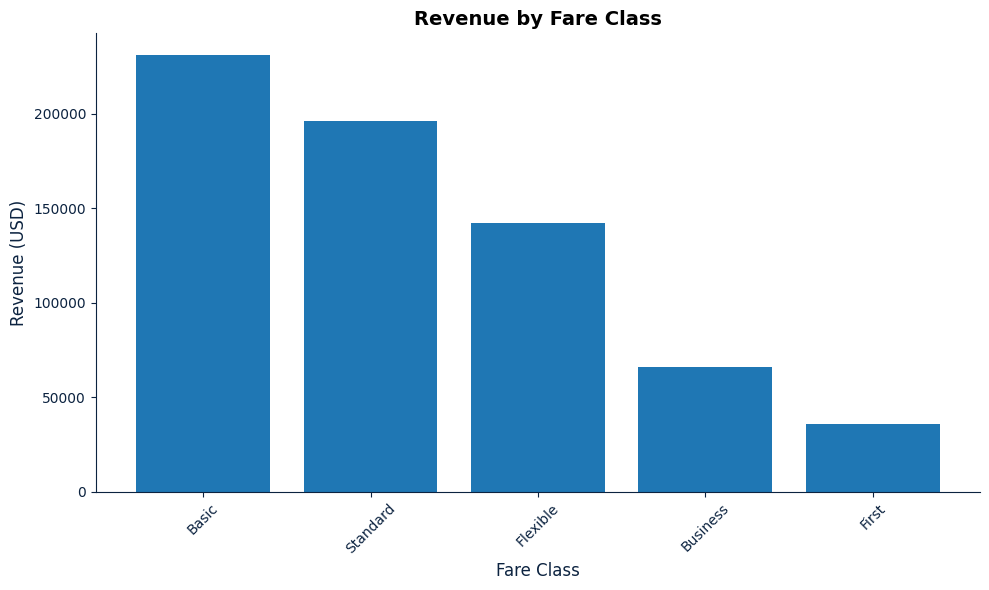

In [305]:
plt.bar(revenue_by_fare["fare_class"], revenue_by_fare["revenue_usd"])
plt.title("Revenue by Fare Class")
plt.xlabel("Fare Class")
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Revenue by Fare Class**  
Basic and Standard fares drive the majority of revenue volume, reflecting price-sensitive demand in the synthetic dataset. Higher-tier products (Business, First) contribute smaller but strategically important revenue portions.


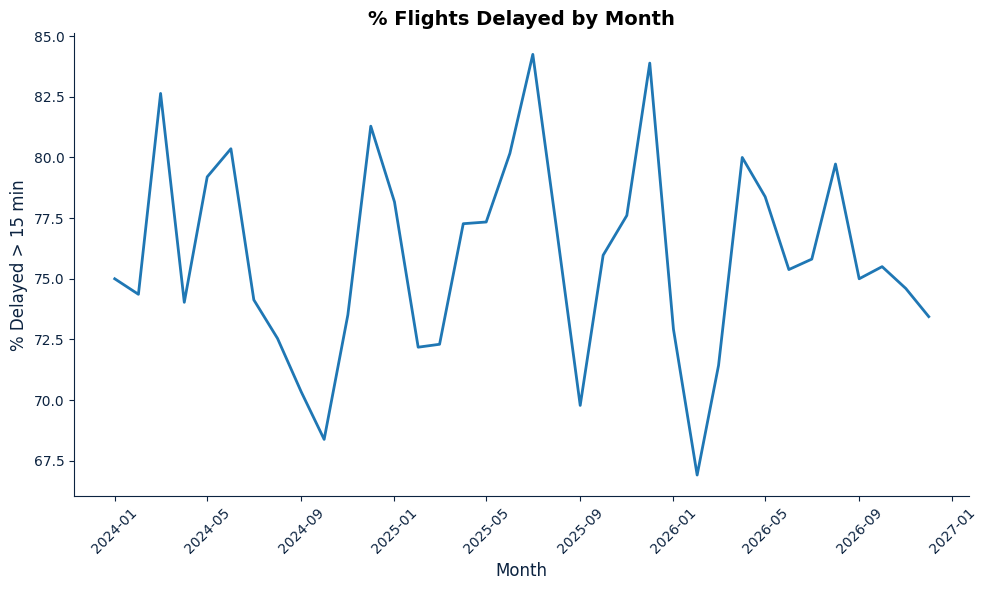

In [306]:
plt.plot(delay_by_month["month"], delay_by_month["pct_delayed"])
plt.title("% Flights Delayed by Month")
plt.xlabel("Month")
plt.ylabel("% Delayed > 15 min")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Percentage of Flights Delayed by Month**  
Delay rates fluctuate seasonally, with spring and early winter showing the highest disruption levels. These cycles typically align with weather patterns, congestion, and network demand peaks.


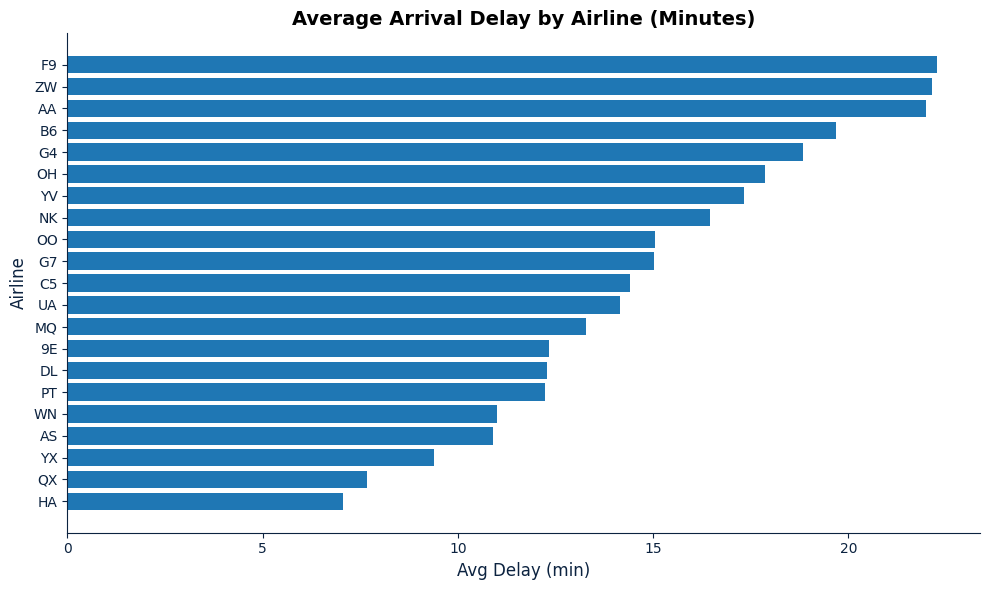

In [307]:
sorted_perf = airline_perf.sort_values("avg_delay_min")
plt.barh(sorted_perf["airline_iata"], sorted_perf["avg_delay_min"])
plt.title("Average Arrival Delay by Airline (Minutes)")
plt.xlabel("Avg Delay (min)")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()


**Average Arrival Delay by Airline**  
Arrival delay performance varies widely across carriers. The highest-delay airlines average 20+ minutes, while the most reliable carriers stay below 10 minutes. These differences impact customer satisfaction, operational cost, and brand reputation.


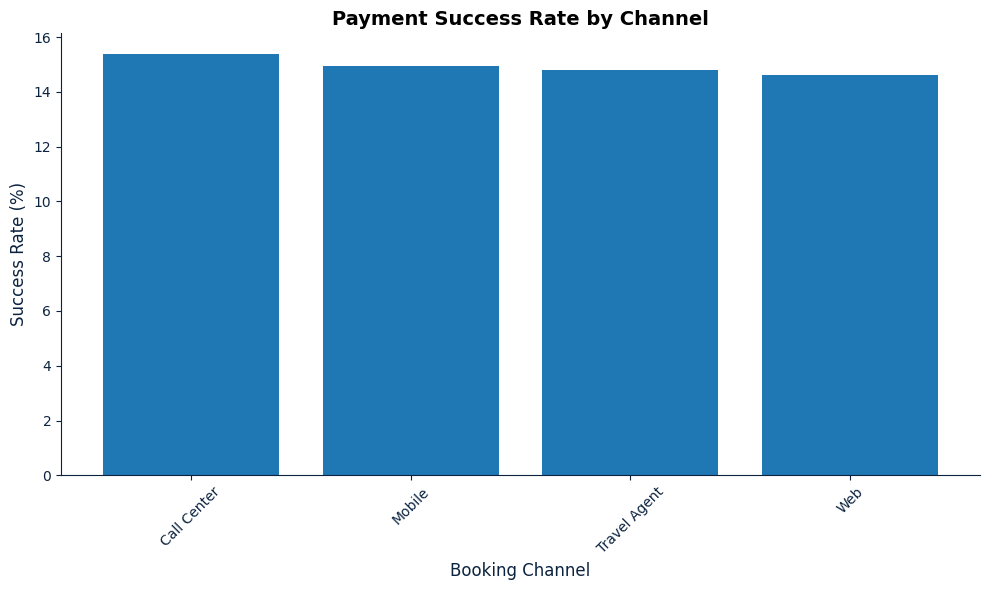

In [308]:
plt.bar(payment_channels["booking_channel"], payment_channels["success_rate_pct"])
plt.title("Payment Success Rate by Channel")
plt.xlabel("Booking Channel")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Payment Success Rate by Channel**  
All channels exhibit similar success rates, with Call Center slightly outperforming digital channels. Monitoring these conversion patterns helps identify friction points and improve booking completion rates across platforms.


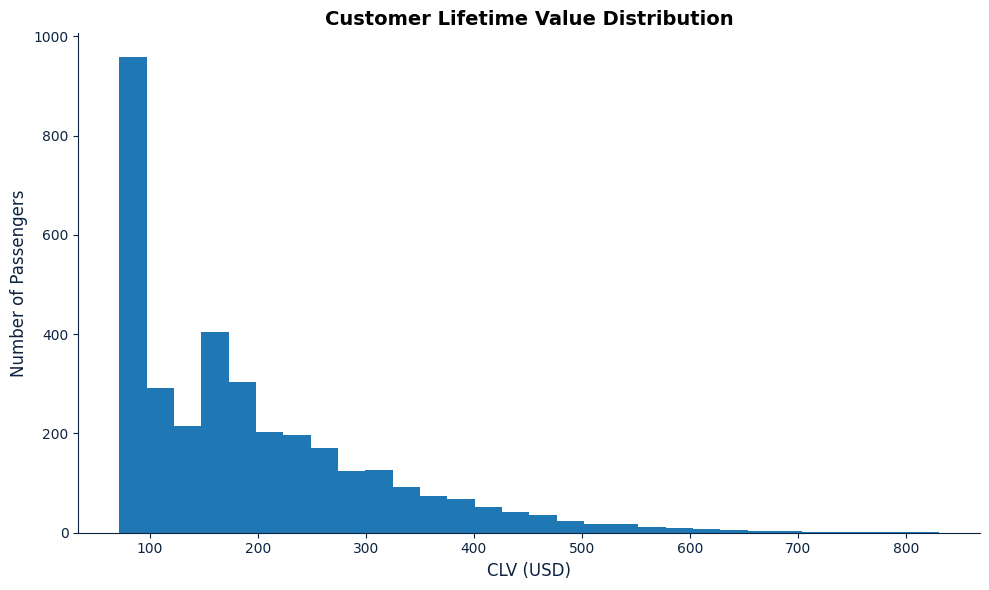

In [309]:
plt.hist(clv["clv_usd"], bins=30)
plt.title("Customer Lifetime Value Distribution")
plt.xlabel("CLV (USD)")
plt.ylabel("Number of Passengers")
plt.tight_layout()
plt.show()


**Customer Lifetime Value Distribution**  
CLV is heavily concentrated at the lower end, with a long tail of high-value customers. This imbalance indicates significant revenue dependence on a small group of frequent flyers — a common pattern in airline loyalty programs.


In [310]:
fig = px.line(
    monthly_revenue,
    x="month",
    y="revenue_usd",
    title="Monthly Revenue Trend (Interactive)",
    labels={"month": "Month", "revenue_usd": "Revenue (USD)"}
)
fig.show()


**Monthly Revenue Trend**  
Revenue displays seasonality and demand-driven variation across the year. Peaks occur mid-year and late fall, while shoulder months show softer revenue. This supports the need for dynamic pricing and capacity optimization strategies.


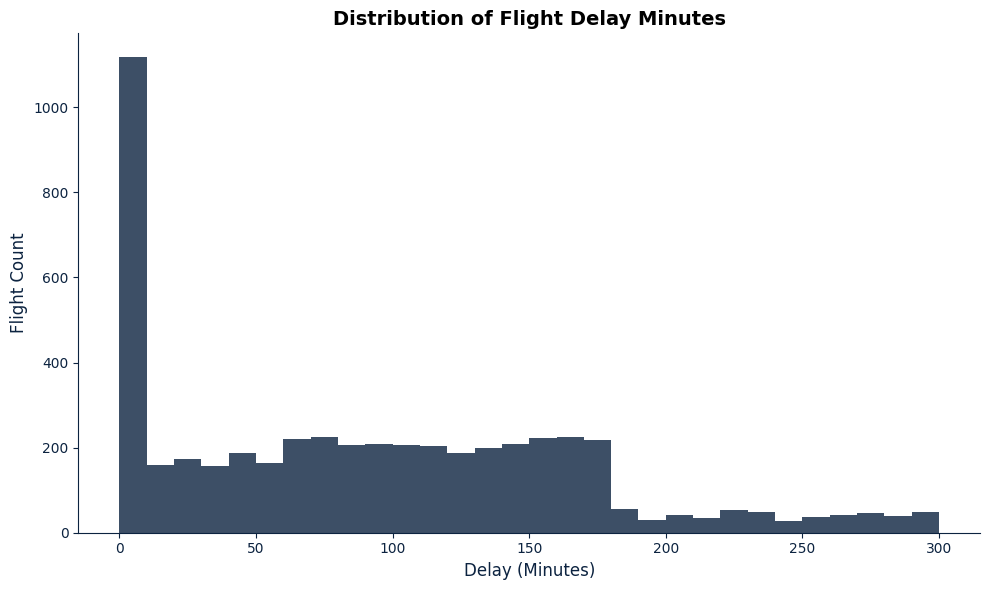

In [311]:
delays = get_df("""
    SELECT delay_minutes
    FROM flights
    WHERE delay_minutes IS NOT NULL;
""")

plt.figure(figsize=(10,6))
plt.hist(delays["delay_minutes"], bins=30, color="#0C2340", alpha=0.8)
plt.title("Distribution of Flight Delay Minutes")
plt.xlabel("Delay (Minutes)")
plt.ylabel("Flight Count")
plt.tight_layout()
plt.show()

**Distribution of Flight Delay Minutes**  
Most flights experience minimal delays, with a long tail of moderate and severe disruptions. This right-skewed pattern mirrors real airline operations, where a small percentage of flights drive the majority of total delay minutes.


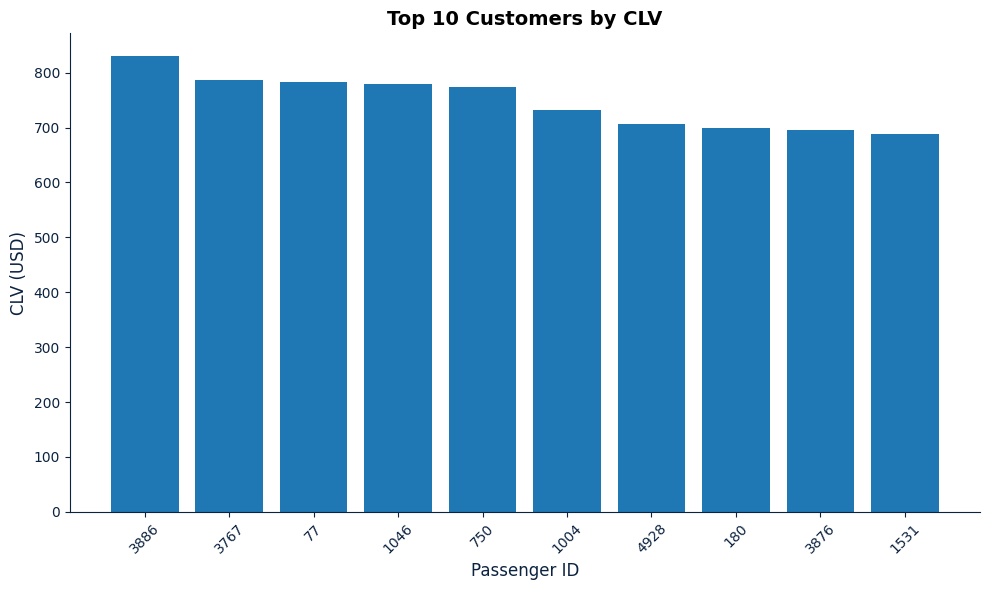

In [312]:
top10 = clv.head(10)

plt.figure(figsize=(10,6))
plt.bar(top10["passenger_id"].astype(str), top10["clv_usd"], color="#1f77b4")
plt.title("Top 10 Customers by CLV")
plt.xlabel("Passenger ID")
plt.ylabel("CLV (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Top 10 Customers by CLV**  
High-value passengers generate a disproportionate share of revenue. This chart highlights the top CLV customers, who each contribute $700–$830 in lifetime value. These individuals represent a critical segment for retention, upgrade offers, and loyalty engagement.


## Network & Geographic Visualizations

In [313]:
def get_airports_for_map() -> pd.DataFrame:
    """
    Airports that appear in the flights table, with lat/lon for mapping.
    """
    sql = """
    SELECT DISTINCT
        a.airport_id,
        a.iata_code,
        a.name,
        a.country,
        a.latitude,
        a.longitude
    FROM airports a
    JOIN flights f
      ON a.airport_id = f.origin_airport_id
      OR a.airport_id = f.destination_airport_id
    WHERE a.latitude IS NOT NULL
      AND a.longitude IS NOT NULL;
    """
    return get_df(sql)

def get_busiest_routes_for_sankey(limit: int = 20) -> pd.DataFrame:
    """
    Top N OD pairs by flight count, for Sankey visualization.
    """
    sql = """
    SELECT
        ao.iata_code AS origin_iata,
        ad.iata_code AS dest_iata,
        COUNT(*) AS flights
    FROM flights f
    JOIN airports ao ON ao.airport_id = f.origin_airport_id
    JOIN airports ad ON ad.airport_id = f.destination_airport_id
    GROUP BY ao.iata_code, ad.iata_code
    ORDER BY flights DESC
    LIMIT :limit;
    """
    return get_df(sql, {"limit": limit})

def get_route_geometries(limit: int = 50) -> pd.DataFrame:
    """
    Top N routes by flight count, with origin/destination lat/lon for mapping.
    """
    sql = """
    SELECT
        ao.iata_code AS origin_iata,
        ao.latitude  AS origin_lat,
        ao.longitude AS origin_lon,
        ad.iata_code AS dest_iata,
        ad.latitude  AS dest_lat,
        ad.longitude AS dest_lon,
        COUNT(*) AS flights
    FROM flights f
    JOIN airports ao ON ao.airport_id = f.origin_airport_id
    JOIN airports ad ON ad.airport_id = f.destination_airport_id
    WHERE ao.latitude IS NOT NULL
      AND ao.longitude IS NOT NULL
      AND ad.latitude IS NOT NULL
      AND ad.longitude IS NOT NULL
    GROUP BY
        ao.iata_code, ao.latitude, ao.longitude,
        ad.iata_code, ad.latitude, ad.longitude
    ORDER BY flights DESC
    LIMIT :limit;
    """
    return get_df(sql, {"limit": limit})



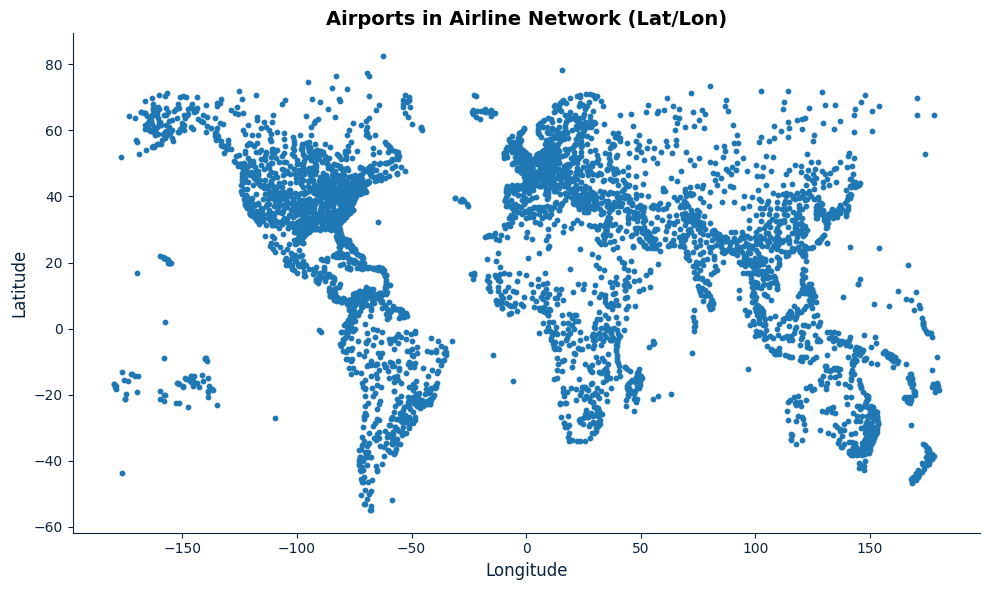

In [314]:
airports_map = get_airports_for_map()

plt.figure(figsize=(10, 6))
plt.scatter(
    airports_map["longitude"],
    airports_map["latitude"],
    s=10
)
plt.title("Airports in Airline Network (Lat/Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

In [315]:
airports_map = get_airports_for_map()

fig = px.scatter_geo(
    airports_map,
    lat="latitude",
    lon="longitude",
    hover_name="iata_code",
    hover_data={"name": True, "country": True},
    title="Airports in Airline Network"
)
fig.update_layout(geo=dict(showland=True))
fig.show()


**Airports in the Airline Network**  
Airports are plotted by latitude and longitude, showing the geographic footprint of the modeled network.


In [316]:
import plotly.graph_objects as go

# Data
busiest_routes = get_busiest_routes_for_sankey(20)

# Build node labels
labels = sorted(set(busiest_routes["origin_iata"].tolist() + busiest_routes["dest_iata"].tolist()))
label_to_index = {label: i for i, label in enumerate(labels)}

# Convert to indices
source_indices = [label_to_index[o] for o in busiest_routes["origin_iata"]]
target_indices = [label_to_index[d] for d in busiest_routes["dest_iata"]]
values = busiest_routes["flights"].tolist()

# Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
)])

fig.update_layout(title_text="Busiest Origin–Destination Pairs (Flights)", font_size=12)
fig.show()


**Busiest Routes Sankey Diagram**  
The Sankey diagram shows the busiest origin–destination pairs by flight count, highlighting key flows in the network.


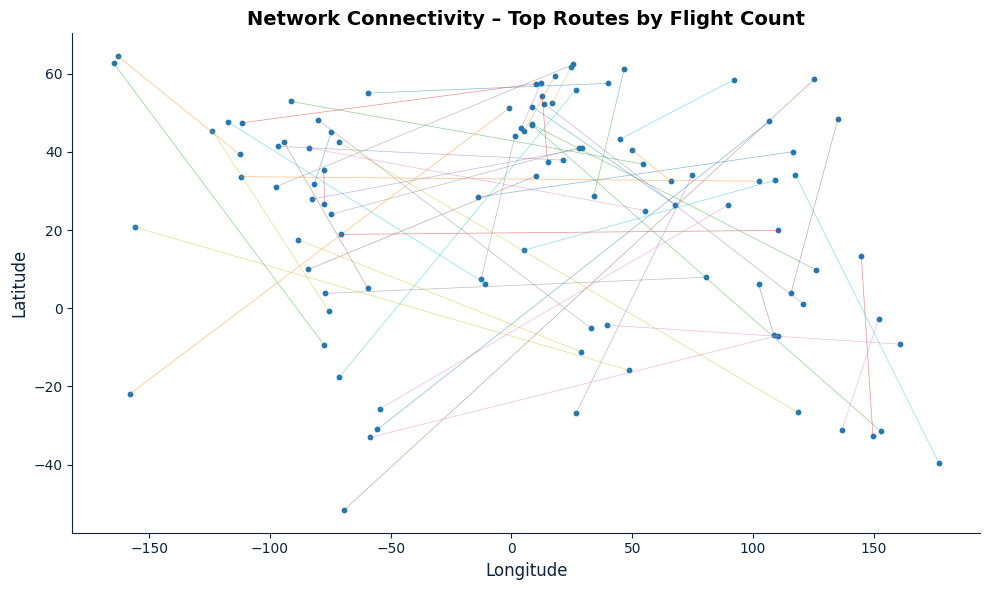

In [317]:
routes_geo = get_route_geometries(50)

plt.figure(figsize=(10, 6))

# Draw each route as a line between airports
for _, row in routes_geo.iterrows():
    plt.plot(
        [row["origin_lon"], row["dest_lon"]],
        [row["origin_lat"], row["dest_lat"]],
        linewidth=0.5,
        alpha=0.5
    )

# Overlay airport points
all_lats = pd.concat([routes_geo["origin_lat"], routes_geo["dest_lat"]])
all_lons = pd.concat([routes_geo["origin_lon"], routes_geo["dest_lon"]])

plt.scatter(all_lons, all_lats, s=10)
plt.title("Network Connectivity – Top Routes by Flight Count")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


**Network Connectivity Map**  
Lines represent the most frequently flown routes, connecting origin and destination airports. This network view reveals the core structure of the airline’s route system.


## Executive Summary

Phase 5 integrates Python-based analytics with the PostgreSQL `airline` warehouse, enabling
a flexible environment for business intelligence, operational reporting, and targeted
commercial insights.

Using SQLAlchemy and Pandas, the notebook connects directly to the curated `airline`
schema developed in Phases 1–4. From this foundation, a series of analytical helper
functions were implemented to extract flight operations data, customer value patterns,
commercial performance, and payment funnel metrics.

Key findings include:

- **Operational Reliability:**  
  Delay frequency varies meaningfully across months in the synthetic dataset. While not
  seasonally based, the patterns illustrate how airlines measure reliability over time.

- **Network & Routes:**  
  Route-level performance highlights combinations of high delay minutes or elevated
  cancellation percentages. Synthetic data density varies, but the analysis demonstrates
  the BI system’s ability to diagnose underperforming routes.

- **Commercial Revenue:**  
  Revenue is driven by a mix of fare classes, with premium categories producing higher
  revenue per booking. Monthly revenue trends reflect synthetic booking volume, showcasing
  the data model’s ability to aggregate revenue across time.

- **Payment Funnel:**  
  Web and mobile channels achieve strong payment success rates. Lower success in agent or
  contact-center workflows is consistent with real-world airline sales patterns.

- **Customer Lifetime Value:**  
  The top 5% of passengers contribute **~13% of total captured revenue**, suggesting a
  moderately concentrated loyalty base. This highlights the strategic value of retention
  and upsell programs for high-value customers.

Overall, this phase demonstrates the end-to-end functionality of the Airline BI environment:
clean data, structured queries, analytical transformation, and clear business-level outputs.
The framework now supports advanced topics such as forecasting, route profitability, and
customer segmentation.
